# Beijing Air Quality

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Andrea Dotti `andrea.dotti4@studio.unibo.it`

Giacomo Pierbattista `giacomo.pierbattista@studio.unibo.it`

Citazioni
 - Beijing Multi-Site Air-Quality Data
 (https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data)

## Parte 1 - Descrizione del problema e analisi esplorativa

Si deve realizzare un modello che, utilizzando i dati registrati da alcuni sensori posti in alcuni distretti di Pechino/Beijing, sia in grado di fare qualcosa di utile.

Vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati e disegnare i grafici.

In [1]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Caricamento dei dati e preprocessing

In [4]:
file_zip_url = "https://raw.githubusercontent.com/jackprb/beijing-air-quality/master/datasets.zip"
file_zip_name = "datasets.zip"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [5]:
# short names for Beijing districts
dict_names = {"Ao" : "Aotizhongxin", 
      "Chang" : "Changping",
      "Ding" : "Dingling",
      "Dong" : "Dongsi",
      "Guan" : "Guanyuan",
      "Guc" : "Gucheng",
      "Hua" : "Huairou",
      "Nong" : "Nongzhanguan",
      "Shu" : "Shunyi",
      "Tia" : "Tiantan",
      "Wanl" : "Wanliu",
      "Wans" : "Wanshouxigong"
     }

frames = []
for name in dict_names.values():
    with open("PRSA_Data_" + name + "_20130301-20170228.csv") as dataFile:
        data_raw = pd.read_csv(dataFile, sep=",")
        frames.append(data_raw)

data_all = pd.concat(frames)
data_all = data_all.drop('No', axis=1)

Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo delle feature che compongono i dati raccolti nel dataset, comprensivo di tutti i 12 file 

In [6]:
data_all.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420768 entries, 0 to 35063
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       418946 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 101.3 MB


Si nota che nel dataset originario, data e ora del rilevamento vengono memorizzate in 4 colonne distinte (year, month, day hour).
Ciò porta ad avere un'occupazione superflua di memoria: di conseguenza, abbiamo deciso di sostituire tali colonne con un'unica nuova feature chiamata `date`, che consente di ridurre l'occupazione di memoria da 101 MB a 91 MB.

In [7]:
#
data_all.insert(0, 'date','')
data_all['date'] = pd.to_datetime(data_all[['year', 'month', 'day', 'hour']])
data_all = data_all.drop(['year', 'month', 'day', 'hour'], axis=1)
data_all.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420768 entries, 0 to 35063
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     420768 non-null  datetime64[ns]
 1   PM2.5    412029 non-null  float64       
 2   PM10     414319 non-null  float64       
 3   SO2      411747 non-null  float64       
 4   NO2      408652 non-null  float64       
 5   CO       400067 non-null  float64       
 6   O3       407491 non-null  float64       
 7   TEMP     420370 non-null  float64       
 8   PRES     420375 non-null  float64       
 9   DEWP     420365 non-null  float64       
 10  RAIN     420378 non-null  float64       
 11  wd       418946 non-null  object        
 12  WSPM     420450 non-null  float64       
 13  station  420768 non-null  object        
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 91.7 MB


### Significato delle feature

Si riporta la descrizione delle feature dal dataset originale: 
https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

`PM2.5`: concentrazione di PM2.5 in ${\mu g}/{m^3}$

`PM10`: concentrazione di PM10 in ${\mu g}/{m^3}$

`SO2`: concentrazione di SO2 in ${\mu g}/{m^3}$

`NO2`: concentrazione di NO2 in ${\mu g}/{m^3}$

`CO`: concentrazione di CO in ${\mu g}/{m^3}$

`O3`: concentrazione di O3 in ${\mu g}/{m^3}$

`TEMP`: temperatura in gradi Celsius `°C`

`PRES`: pressione in `hPa`

`DEWP`: temperatura del punto di rugiata in gradi Celsius `°C`

`RAIN`: precipitazioni in `mm`

`wd`: direzione del vento

`WSPM`: velocità del vento in `m/s`

`station`: nome della località dove sono stati rilevati i dati

### Esplorazione singole feature

E' possibile visualizzare media, deviazione standard e la distribuzione in termini di massimi, minimi e percentili per le colonne con valori numerici utilizzando il metodo `describe()`.

In [8]:
data_all.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


Con i metodi `isnull().sum(0)` si contano quanti valori mancano nel dataset, contando per righe.

Tale risultato viene poi ordinato in senso crescente per visualizzare quali features hanno più dati mancanti.

In [9]:
data_all.isnull().sum(0).sort_values(ascending=False)

CO         20701
O3         13277
NO2        12116
SO2         9021
PM2.5       8739
PM10        6449
wd          1822
DEWP         403
TEMP         398
PRES         393
RAIN         390
WSPM         318
date           0
station        0
dtype: int64

Si osserva che le prime 6 features con più dati mancanti sono:
 - CO
 - O3
 - NO2
 - SO2
 - PM2.5
 - PM10
 
Da notare che le PM2.5 e le PM10 sono comunemente note come "polveri sottili" e "particolato" rispettivamente e
costituiscono i principali inquinanti nelle aree urbane.

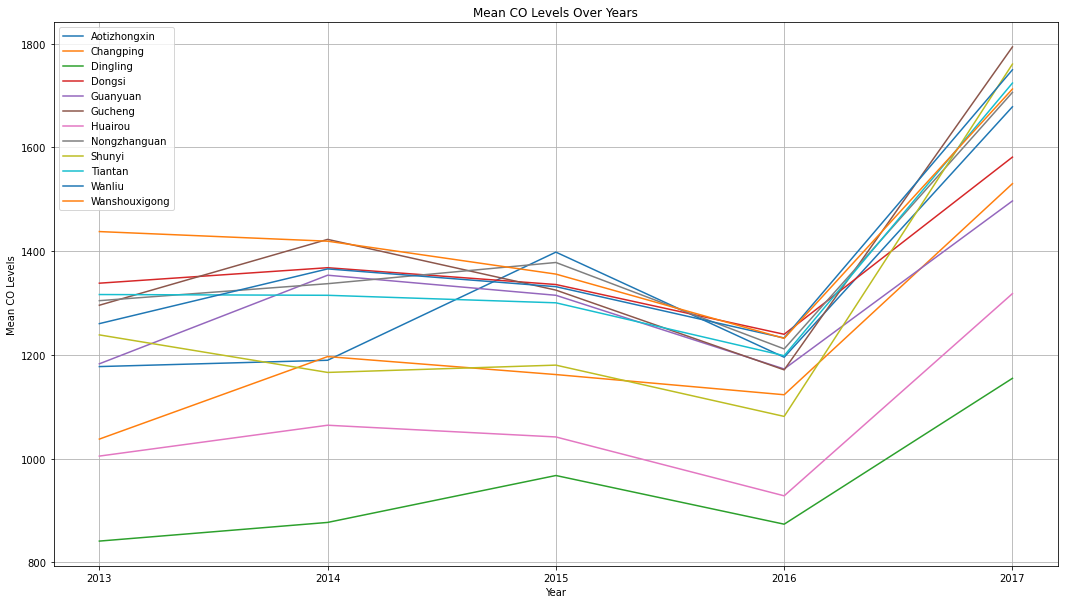

In [21]:
# Group the data by cities and year, and calculate mean CO for each group
grouped = data_all.groupby(['station', data_all['date'].dt.year])['CO'].mean().reset_index()

# Create a Matplotlib figure and axis
plt.figure(figsize=(18, 10))


# Plot mean CO values over years for each city
for city, group in grouped.groupby('station'):
    plt.plot(group['date'], group['CO'], label=city)

plt.xticks(grouped['date'].unique())
# Customize the plot
plt.title('Mean CO Levels Over Years')
plt.xlabel('Year')
plt.ylabel('Mean CO Levels')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
data_copy